In [1]:
!nvidia-smi

Fri Apr  5 14:56:59 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  Off |
|  0%   49C    P8    20W / 450W |      0MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# !pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org display_tree
# !pip3 install requests==2.27.0
# !pip show requests

In [3]:
import os

os.environ["http_proxy"]  = "http://proxy.ad.speechpro.com:3128"
os.environ["https_proxy"] = "http://proxy.ad.speechpro.com:3128"
os.environ["ftp_proxy"]   = "http://proxy.ad.speechpro.com:3128"

# os.environ['CURL_CA_BUNDLE'] = ''

In [4]:
# from cutils import create_chunk_dataset, del_folder, load_checkpoint
from calc_content import create_hubert_content
from clustering import incremental_clustering, PseudoPhonemes
from dataset import Text2PseudoPhonemes
from models import TextEncoder, TransformerDecoder, Seq2Seq, WhisperX
from train import train, speech_editing, init_decoder, init_textencoder, init_dataset

from pathlib import Path
from typing import *
import json

import whisperx
import matplotlib.pyplot as plt
import wget
import torch
from safetensors.torch import load_file
from torch.utils.data import DataLoader

%matplotlib inline


# !pip install anyascii
            #  gruut
            #  bnunicodenormalizer
            #  bnnumerizer
            #  bangla
            #  inflect
            #  jamo
            #  jieba
            #  pypinyin
            # mutagen
# from TTS.tts.utils.text.tokenizer import TTSTokenizer
# from TTS.tts.configs.vits_config import VitsConfig


def path(_path):
    return "./examples/" / Path(_path)


import os
os.environ['TRANSFORMERS_CACHE'] = "/mnt/storage/kocharyan/hfmodels"

  torchaudio.set_audio_backend("soundfile")



### Create test dataset

In [8]:
create_chunk_dataset("../../NIR/RuDevices", out_dataset=path("rudevices_chunk"), display=True)

rudevices_chunk/
├── 2/
│   ├── b/
│   │   ├── 2ea73463-c1e5-4d4f-93a6-055f6ef159cb.txt
│   │   ├── 2ea73463-c1e5-4d4f-93a6-055f6ef159cb.wav
│   │   ├── 316cb6f3-5974-4371-a868-2c531a3087e8.txt
│   │   ├── 316cb6f3-5974-4371-a868-2c531a3087e8.wav
│   │   ├── dc080bc6-089d-4f6d-b033-1d867e747a3a.txt
│   │   ├── dc080bc6-089d-4f6d-b033-1d867e747a3a.wav
│   │   ├── dd9262b6-bb56-4ffa-9458-2790458ce27e.txt
│   │   └── dd9262b6-bb56-4ffa-9458-2790458ce27e.wav
│   └── c/
│       ├── 289d5d71-83a3-417c-b5b7-9595e41efd88.txt
│       ├── 289d5d71-83a3-417c-b5b7-9595e41efd88.wav
│       ├── 3ca91220-5827-459f-abdc-562247a8f854.txt
│       ├── 3ca91220-5827-459f-abdc-562247a8f854.wav
│       ├── 42568ca3-ac48-4307-8280-8541f6262536.txt
│       ├── 42568ca3-ac48-4307-8280-8541f6262536.wav
│       ├── 6cab54ad-cf57-40b6-b67b-559f9c33f027.txt
│       └── 6cab54ad-cf57-40b6-b67b-559f9c33f027.wav
└── 7/
    ├── 5/
    │   ├── 42e7dd00-9a76-4c18-8f31-370b44763cd0.txt
    │   ├── 42e7dd00-9a76-4c18-8f31

In [10]:
# !ls examples/rudevices_chunk/1/1/

In [11]:
# git clone lengyue233/content-vec-best

In [12]:
# !mkdir ../../hfmodels
# download_hf_model("lengyue233/content-vec-best", "../../hfmodels") #TODO: Add final proj layer in lengyue233/content-vec-best

### Create HuBERT contents & Clustering

In [13]:
#TODO: Add final proj layer in lengyue233/content-vec-best
del_folder(path("extracted_contents"))
create_hubert_content(
    data_dir=path("rudevices_chunk"), out_dir=path("extracted_contents"), 
    njobs=1, pretrain_path="../../hfmodels/content-vec-best",
    )

  return self.fget.__get__(instance, owner)()



n_jobs=1
{'hmodel_id': '../../hfmodels/content-vec-best', 'data_sr': 16000, 'out_dir': PosixPath('examples/extracted_contents'), 'device': 'cuda', 'rel_to': PosixPath('examples/rudevices_chunk')}


Some weights of HubertModel were not initialized from the model checkpoint at ../../hfmodels/content-vec-best and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 16/16 [00:03<00:00,  4.01it/s]


In [14]:
incremental_clustering(
    path("extracted_contents"), path("clusters/clusters.pt"),
    n_clusters=100, batch_size=5, data_pattern="*.content.pt"
    )

hubert contents shape: (828, 768), 2.43 MB
hubert contents shape: (870, 768), 2.55 MB
hubert contents shape: (872, 768), 2.55 MB
hubert contents shape: (191, 768), 0.56 MB
Clustering time 0.33 seconds


In [15]:
cluster = PseudoPhonemes(path("clusters/clusters.pt"))
cluster.build_clusters()

In [16]:
data = torch.load(path("clusters/clusters.pt"))
print(data['cluster_centers'].shape)
item = (data['cluster_centers'][50] + data['cluster_centers'][25]).reshape(1, -1)
print(cluster.predict_cluster_center(item))
print(cluster.get_cluster_center(item).shape)

(100, 768)
[50]
(1, 768)


In [17]:
!ls ../../hfmodels/content-vec-best

config.json  convert.py  pytorch_model.bin  README.md


### Prepare Dataset

In [5]:
# conf_p = "../../NIR/YourTTS-RU-RUSLAN-April-30-2023_03+48PM-0000000/config.json"
dataset = Text2PseudoPhonemes(
    path("rudevices_chunk"), path("extracted_contents"), path("clusters/clusters.pt"), 
    None, None, "ckpts/yourrtts_config.json", #pretrain path m.b. "../../hfmodels/content-vec-best"
    )

In [6]:
# batch = next(iter(dataset))
# batch['pseudo_ph'].shape, 

# batch = next(iter(DataLoader(dataset, batch_size=2, collate_fn=lambda x: x)))

# batch = next(iter(DataLoader(dataset, batch_size=2, collate_fn=dataset.collate_fn)))
# batch['tokens_padded'].shape, batch['lables'].shape, 

# !mkdir ckpts
# !cp ../../NIR/YourTTS-RU-RUSLAN-April-30-2023_03+48PM-0000000/best_model_158996.pth ckpts/yourtts_ruslan.pth

In [7]:
len(dataset.tokenizer.characters.vocab)

177

In [8]:
n_vocab         = len(dataset.tokenizer.characters.vocab) # 177
inter_channels  = 192
hidden_channels = 192
filter_channels = 768
n_heads         = 2
n_layers        = 10 # 6/10 for YourTTS
kernel_size     = 3
p_dropout       = .1

prior_encoder = TextEncoder(
    n_vocab, inter_channels, hidden_channels, filter_channels, 
    n_heads, n_layers, kernel_size, p_dropout,
)   

In [9]:
prior_encoder, conf = load_checkpoint(prior_encoder,
                                "ckpts/yourtts_ruslan.pth", 
                                "text_encoder", False)

  return self.fget.__get__(instance, owner)()



In [15]:
batch = next(iter(DataLoader(dataset, batch_size=1, collate_fn=dataset.collate_fn)))
batch

{'tokens_padded': tensor([[140, 127, 175, 145, 143, 135, 131, 149, 127, 145, 155, 175, 150, 127,
          144, 141, 129]]),
 'lables': tensor([[100,  68,  44,  44,  86,  91,  91,  22,  22,  22,  22,  22,  22,  77,
           48,  10,   9,  27,  78,  78,  78,  39,  39,  75,  42,  72,  72,  72,
           55,  55,  13,  13,  13,  13,  79,  79,  98,  61,  61,  61,  61,  61,
           45,  45,  45,  66,  66,  66,  66,  66,  40,  40,  40,  40,  34,  34,
           34,  34,  34,   6,   6,   6,   6,   6,   6,   6,   6,   6,  81,  81,
           81,  81,  81,  81,  81,  81,  24,  24,  24,  24,  24,  24,  24,  24,
           87,  87,  87,  87,  87,  87,  87,  87,  68,  49,  49,  49,  49,  49,
           68,  49,  49,  49,  68,  49,  14,  14,   0,   0, 101]]),
 'text_lens': tensor([17])}

In [22]:
import numpy as np
np.ones((3, 4))[:-1, :].shape

(2, 4)

In [29]:
batch = next(iter(DataLoader(dataset, batch_size=3, collate_fn=dataset.collate_fn)))
print(batch["lables"].shape)
print(batch["lables"][:, :-1].shape)

torch.Size([3, 314])
torch.Size([3, 313])


In [11]:
batch = next(iter(DataLoader(dataset, batch_size=3, collate_fn=dataset.collate_fn)))
print(f"{batch['tokens_padded'].shape=}")
enc_out = prior_encoder(batch["tokens_padded"], batch["text_lens"])[0]#.permute((0, 2, 1))
enc_out.shape

batch['tokens_padded'].shape=torch.Size([3, 98])


torch.Size([3, 192, 98])

In [12]:
decoder = TransformerDecoder(1, 192, 300, 1, dataset.gen_pad + 1, .1, dataset.gen_pad, dataset.gen_bos, dataset.gen_eos) #TODO dataset.gen_pad + 1
decoder(enc_out, batch['lables']).shape, batch['lables'].shape

(torch.Size([3, 314, 103]), torch.Size([3, 314]))

In [14]:
seq2seq = Seq2Seq(prior_encoder, decoder)
seq2seq(batch).shape

torch.Size([3, 314, 103])

### Train

In [6]:
losses, model, dataset = train() # 3 layers

DEBUG: src_emb.shape=torch.Size([16, 98, 192]) tgt_emb.shape=torch.Size([16, 344, 192])
Epoch: 1, Train loss: 5.492061614990234, Time: 0.031 min
DEBUG: src_emb.shape=torch.Size([16, 98, 192]) tgt_emb.shape=torch.Size([16, 344, 192])
DEBUG: src_emb.shape=torch.Size([16, 98, 192]) tgt_emb.shape=torch.Size([16, 344, 192])


KeyboardInterrupt: 

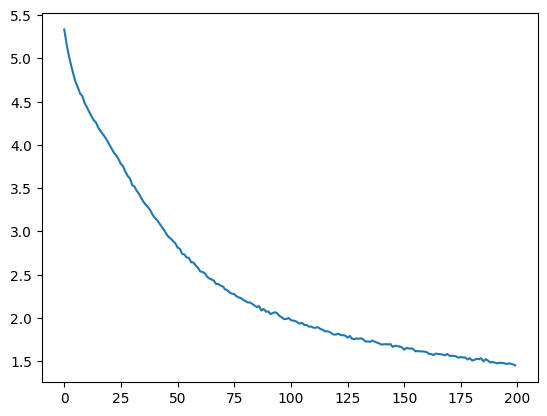

In [6]:
plt.plot(losses)
plt.show()

### Decoding

In [6]:
whisperx_model = WhisperX() 

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../home/stc/.cache/torch/whisperx-vad-segmentation.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.1.2+cu118. Bad things might happen unless you revert torch to 1.x.


Some weights of the model checkpoint at /mnt/storage/kocharyan/hfmodels/wav2vec2-large-xlsr-53-russian/ were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at /mnt/storage/kocharyan/hfmodels/wav2vec2-large-xlsr-53-russian/ and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.p

In [4]:
!ls ./examples/rudevices_chunk/2/b/

2ea73463-c1e5-4d4f-93a6-055f6ef159cb.txt
2ea73463-c1e5-4d4f-93a6-055f6ef159cb.wav
316cb6f3-5974-4371-a868-2c531a3087e8.txt
316cb6f3-5974-4371-a868-2c531a3087e8.wav
dc080bc6-089d-4f6d-b033-1d867e747a3a.txt
dc080bc6-089d-4f6d-b033-1d867e747a3a.wav
dd9262b6-bb56-4ffa-9458-2790458ce27e.txt
dd9262b6-bb56-4ffa-9458-2790458ce27e.wav


In [26]:
from IPython.display import Audio

Audio("./examples/rudevices_chunk/2/b/dd9262b6-bb56-4ffa-9458-2790458ce27e.wav", rate=16_000)

In [10]:
!cat ./examples/rudevices_chunk/2/b/dd9262b6-bb56-4ffa-9458-2790458ce27e.txt #--> скачок который видел в конце графика

скачок который видел в начале графика

In [12]:
bp = "./examples/rudevices_chunk/2/b/"
audio = WhisperX.load_audio(bp+'dd9262b6-bb56-4ffa-9458-2790458ce27e.wav')
out = whisperx_model(audio)
alignment = WhisperX.postprocess_out(out, by='words')
alignment

Detected language: ru (0.99) in first 30s of audio...


[{'word': 'Скачок,', 'start': 0.089, 'end': 0.532, 'score': 0.919},
 {'word': 'который', 'start': 0.572, 'end': 0.874, 'score': 0.927},
 {'word': 'виден', 'start': 0.914, 'end': 1.135, 'score': 0.552},
 {'word': 'в', 'start': 1.155, 'end': 1.175, 'score': 1.0},
 {'word': 'начале', 'start': 1.215, 'end': 1.557, 'score': 0.984},
 {'word': 'графика.', 'start': 1.618, 'end': 2.08, 'score': 1.0}]

In [33]:
out['segments'][0]['text']

' Скачок, который виден в начале графика.'

In [20]:
WhisperX.formed_timesteps(alignment)

{0: ('скачок,', [range(4, 27)]),
 1: ('который', [range(28, 44)]),
 2: ('виден', [range(45, 57)]),
 3: ('в', [range(57, 59)]),
 4: ('начале', [range(60, 78)]),
 5: ('графика.', [range(80, 105)])}

In [7]:
torch.save(model.state_dict(), "ckpts/seq2seq.pkl")

In [3]:
dataset = init_dataset()
encoder, decoder = init_textencoder(dataset), init_decoder(dataset)
model = Seq2Seq(encoder, decoder)
model.load_state_dict(torch.load("ckpts/seq2seq.pkl"))
model.eval();


In [5]:
bp = "./examples/rudevices_chunk/2/b/"
audio_f = bp+'dd9262b6-bb56-4ffa-9458-2790458ce27e.wav'
src_text = 'скачок который видел в начале графика'
target_text = 'скачок который видел в конце графика'
model = "ckpts/seq2seq.pkl"


speech_editing(audio_f, src_text, target_text, None, model)

Some weights of HubertModel were not initialized from the model checkpoint at /mnt/storage/kocharyan/hfmodels/content-vec-best and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DEBUG contents.shape=torch.Size([1, 134, 768])
No language specified, language will be first be detected for each audio file (increases inference time).


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../home/stc/.cache/torch/whisperx-vad-segmentation.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.1.2+cu118. Bad things might happen unless you revert torch to 1.x.


Some weights of the model checkpoint at /mnt/storage/kocharyan/hfmodels/wav2vec2-large-xlsr-53-russian/ were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at /mnt/storage/kocharyan/hfmodels/wav2vec2-large-xlsr-53-russian/ and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.p

Detected language: ru (0.99) in first 30s of audio...
DEBUG timesteps={0: ('скачок,', [range(4, 27)]), 1: ('который', [range(28, 44)]), 2: ('виден', [range(45, 57)]), 3: ('в', [range(57, 59)]), 4: ('начале', [range(60, 78)]), 5: ('графика.', [range(80, 105)])}
DEBUG: model.decoder.target_vocab_size=103
DEBUG: memory.shape=torch.Size([1, 36, 192])
DEBUG: i=0
DEBUG: src_emb.shape=torch.Size([1, 36, 192]) tgt_emb.shape=torch.Size([1, 1, 192])
DEBUG: prob.shape=torch.Size([1, 1, 192])
DEBUG: next_symb=68
DEBUG: i=1
DEBUG: src_emb.shape=torch.Size([1, 36, 192]) tgt_emb.shape=torch.Size([1, 2, 192])
DEBUG: prob.shape=torch.Size([1, 2, 192])
DEBUG: next_symb=68
DEBUG: i=2
DEBUG: src_emb.shape=torch.Size([1, 36, 192]) tgt_emb.shape=torch.Size([1, 3, 192])
DEBUG: prob.shape=torch.Size([1, 3, 192])
DEBUG: next_symb=68
DEBUG: i=3
DEBUG: src_emb.shape=torch.Size([1, 36, 192]) tgt_emb.shape=torch.Size([1, 4, 192])
DEBUG: prob.shape=torch.Size([1, 4, 192])
DEBUG: next_symb=68
DEBUG: i=4
DEBUG: src_e

array([[100,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,
         68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,
         68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,
         68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,
         68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,
         68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,
         68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,
         68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,
         68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,
         68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,
         68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,
         68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,
         68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,
         68,  68,  68,  68,  68,  68,  68,  68,  68

In [ ]:
# DEBUG: src_emb.shape=torch.Size([1, 36, 192]) tgt_emb.shape=torch.Size([2, 1, 192])
# DEBUG: src_emb.shape=torch.Size([16, 98, 192]) tgt_emb.shape=torch.Size([16, 344, 192])

In [10]:
_ = torch.rand((1, 3, 5))
print(_)
_[:, -1, :]

tensor([[[0.7778, 0.7936, 0.2052, 0.7388, 0.5789],
         [0.7664, 0.4013, 0.7040, 0.6563, 0.3191],
         [0.0614, 0.9484, 0.3690, 0.4721, 0.4780]]])


tensor([[0.0614, 0.9484, 0.3690, 0.4721, 0.4780]])